In [51]:
from keras.layers import LSTM
from keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#standardize the data
from sklearn.preprocessing import StandardScaler

In [52]:
def load_data(path):
    df = pd.read_csv(path)
    print(df.info())
    #convert the date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    print(df.head())
    print(df.info())
    return df


In [53]:
path='/Users/rianrachmanto/pypro/data/esp_new.csv'
df = load_data(path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202978 entries, 0 to 202977
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Well             202978 non-null  object 
 1   Date             202978 non-null  object 
 2   Hours_Online     91217 non-null   float64
 3   Freq             79585 non-null   float64
 4   Ampere           83274 non-null   float64
 5   Volt             76026 non-null   float64
 6   Press_Discharge  57558 non-null   float64
 7   TM               39661 non-null   float64
 8   Vibration        36035 non-null   float64
 9   Gross_Rate       85310 non-null   float64
dtypes: float64(8), object(2)
memory usage: 15.5+ MB
None
  Well       Date  Hours_Online  Freq  Ampere   Volt  Press_Discharge     TM  \
0  BC1 2011-09-02          24.0   NaN    19.2  343.2              NaN  175.0   
1  BC1 2011-09-03          24.0   NaN    18.3  339.6              NaN  177.4   
2  BC1 2011-09-04          

In [54]:
def select_freq(df, well_name):
    # Filter the DataFrame for the given well name
    df_freq = df[df['Well'] == well_name][['Well', 'Date', 'Volt']]
    print(df_freq.head())
    return df_freq


In [55]:
df_freq = select_freq(df, 'BS3')

     Well       Date   Volt
9277  BS3 2011-09-01    NaN
9278  BS3 2011-09-02  430.0
9279  BS3 2011-09-03  428.4
9280  BS3 2011-09-04  421.0
9281  BS3 2011-09-05  428.0


In [56]:
def train_test (df_freq):
    #split based on length of the data with 80% training and 20% testing
    train_size = int(len(df_freq) * 0.8)
    test_size = len(df_freq) - train_size
    train, test = df_freq.iloc[0:train_size], df_freq.iloc[train_size:len(df_freq)]
    print(train.shape, test.shape)
    print(train.head())
    return train, test

In [57]:
train, test = train_test(df_freq)

(3711, 3) (928, 3)
     Well       Date   Volt
9277  BS3 2011-09-01    NaN
9278  BS3 2011-09-02  430.0
9279  BS3 2011-09-03  428.4
9280  BS3 2011-09-04  421.0
9281  BS3 2011-09-05  428.0


In [58]:
def clean_train(train):
    #drop all the missing values
    train = train.dropna()
    print(train.shape)
    print(train.head())
    return train

def clean_test(test):
    #drop all the missing values
    test = test.dropna()
    print(test.shape)
    print(test.head())
    return test

In [59]:
train = clean_train(train)
test = clean_test(test)

(1176, 3)
     Well       Date   Volt
9278  BS3 2011-09-02  430.0
9279  BS3 2011-09-03  428.4
9280  BS3 2011-09-04  421.0
9281  BS3 2011-09-05  428.0
9282  BS3 2011-09-06  420.0
(571, 3)
      Well       Date   Volt
13135  BS3 2022-03-25  329.0
13136  BS3 2022-03-26  343.0
13142  BS3 2022-04-01  401.0
13143  BS3 2022-04-02  401.0
13144  BS3 2022-04-03  400.0


In [60]:
#plot the data as time series
def plot_data(train):
    plt.figure(figsize=(12,6))
    plt.plot(train['Date'], train['Volt'])
    plt.title('Frequency vs Time')
    plt.ylabel('Frequency')
    plt.xlabel('Date')
    plt.show()

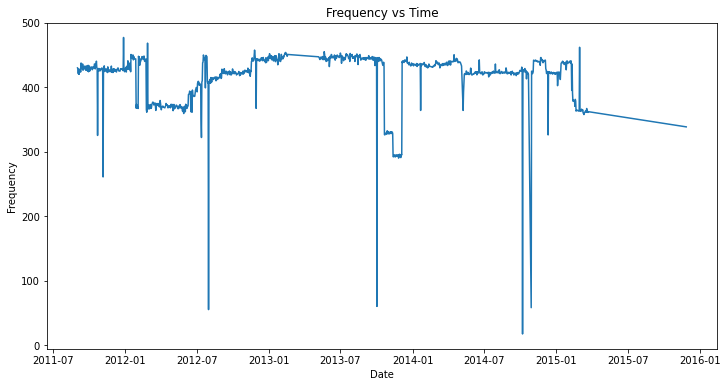

In [61]:
plot_data(train)

In [62]:
#preprocess train data to standardize the data
def preprocess_train(train, test):
    # Create copies of the input DataFrames to avoid modifying original data
    scaled_train = train.copy()
    scaled_test = test.copy()

    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler on the training data
    scaler = scaler.fit(train[['Volt']])

    # Transform the 'Freq' column for both training and testing data
    scaled_train['Volt'] = scaler.transform(train[['Volt']])
    scaled_test['Volt'] = scaler.transform(test[['Volt']])

    print(scaled_train.head())
    return scaled_train, scaled_test


In [63]:
scaled_train,scaled_test = preprocess_train(train,test)

     Well       Date      Volt
9278  BS3 2011-09-02  0.315679
9279  BS3 2011-09-03  0.275282
9280  BS3 2011-09-04  0.088447
9281  BS3 2011-09-05  0.265183
9282  BS3 2011-09-06  0.063199


In [64]:
import numpy as np

def create_sequences(data, n_steps):
    X = []
    for i in range(len(data) - n_steps):
        # Define the end of the sequence
        end_ix = i + n_steps
        # Gather input and output parts of the pattern
        seq_x = data[i:end_ix]
        X.append(seq_x)
    return np.array(X)


In [65]:
# Assuming you have already called preprocess_train and obtained scaled_train and scaled_test
n_steps = 24
# Convert DataFrame to numpy array for easier manipulation
train_freq = scaled_train['Volt'].values
test_freq = scaled_test['Volt'].values

# Create sequences
X_train = create_sequences(train_freq, n_steps)
X_test = create_sequences(test_freq, n_steps)

# Print the shapes to understand the dimensions
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (1152, 24)
Test data shape: (547, 24)


In [66]:
# Reshape the data for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Reshaped training data shape:", X_train.shape)
print("Reshaped test data shape:", X_test.shape)


Reshaped training data shape: (1152, 24, 1)
Reshaped test data shape: (547, 24, 1)


In [67]:
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

def build_autoencoder(timesteps, n_features):
    # Encoder
    encoder = Sequential()
    encoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=False))
    encoder.add(RepeatVector(timesteps))  # This helps to repeat the context vector for the decoder

    # Decoder
    decoder = Sequential()
    decoder.add(LSTM(32, activation='relu', return_sequences=True))
    decoder.add(TimeDistributed(Dense(n_features)))  # Wraps Dense layer to output sequence

    # Autoencoder
    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Define your autoencoder model
time_steps = 24  # Number of time steps in each sequence
n_features = 1  # You have one feature per time step (Freq)
autoencoder = build_autoencoder(time_steps, n_features)
autoencoder.summary()  # Print the model architecture


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 24, 32)            4352      
                                                                 
 sequential_7 (Sequential)   (None, 24, 1)             8353      
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
# Train the model
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
33/33 [==============================] - 41s 1s/step - loss: 0.8029 - val_loss: 0.3066
Epoch 2/50
33/33 [==============================] - 29s 884ms/step - loss: 0.6150 - val_loss: 0.2283
Epoch 3/50
33/33 [==============================] - 29s 884ms/step - loss: 0.5563 - val_loss: 0.2040
Epoch 4/50
33/33 [==============================] - 30s 905ms/step - loss: 0.5379 - val_loss: 0.2015
Epoch 5/50
33/33 [==============================] - 31s 949ms/step - loss: 0.5355 - val_loss: 0.1975
Epoch 6/50
33/33 [==============================] - 32s 955ms/step - loss: 0.5255 - val_loss: 0.1947
Epoch 7/50
33/33 [==============================] - 33s 986ms/step - loss: 0.5156 - val_loss: 0.1949
Epoch 8/50
33/33 [==============================] - 32s 985ms/step - loss: 0.5019 - val_loss: 0.1887
Epoch 9/50
33/33 [==============================] - 33s 996ms/step - loss: 0.5013 - val_loss: 0.1856
Epoch 10/50
33/33 [==============================] - 34s 1s/step - loss: 0.4772 - val_loss: 0.

In [69]:
import numpy as np

# Assuming X_test is your test dataset already prepared
predicted = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(predicted - X_test), axis=1)


18/18 [==============================] - 4s 155ms/step


In [70]:
threshold = np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors)
print("Anomaly detection threshold:", threshold)


Anomaly detection threshold: 2.4071029439081353


In [71]:
anomalies = reconstruction_errors > threshold
print("Number of detected anomalies:", np.sum(anomalies))


Number of detected anomalies: 13


In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming reconstruction_errors and threshold are already defined
anomalies = reconstruction_errors > threshold
any_anomalies = np.any(anomalies)  # Check if there are any True values in anomalies


In [73]:
# Assuming reconstruction_errors and threshold are already defined
anomalies = reconstruction_errors > threshold
print("Type of anomalies:", anomalies.dtype)  # Should output dtype('bool')
print("Sample of anomalies array:", anomalies[:10])  # See a few values


Type of anomalies: bool
Sample of anomalies array: [[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [74]:
print("Reconstruction Errors Shape:", reconstruction_errors.shape)


Reconstruction Errors Shape: (547, 1)


In [75]:
reconstruction_errors = reconstruction_errors.flatten()


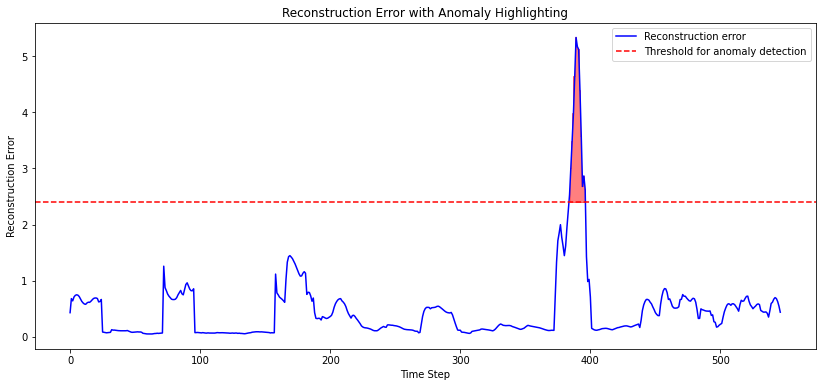

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming reconstruction_errors and threshold are already defined
anomalies = (reconstruction_errors > threshold).flatten()
time_steps = np.arange(len(reconstruction_errors))

plt.figure(figsize=(14, 6))

# Plot the entire reconstruction error line
plt.plot(time_steps, reconstruction_errors, label='Reconstruction error', color='blue')

# Overlay anomalies in red
plt.fill_between(time_steps, reconstruction_errors, threshold, where=anomalies, color='red', step='pre', alpha=0.5)

# Add threshold line
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold for anomaly detection')

plt.title('Reconstruction Error with Anomaly Highlighting')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()
